In [20]:
# Dependencies 
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from scipy.stats import linregress

In [21]:
# Try opening the CSV file with different encodings

nfl_teams = pd.read_csv("archive/nfl_teams.csv")
scores_data = pd.read_csv("archive/spreadspoke_scores.csv")


encodings_to_try = ["utf-8", "latin-1", "ISO-8859-1"]

for encoding in encodings_to_try:
    try:
        with open("archive/nfl_stadiums.csv", encoding=encoding) as file:
            stadiums = pd.read_csv(file)
        break  # Stop trying encodings if successful
    except UnicodeDecodeError:
        continue  # Try the next encoding if unsuccessful

# If none of the encodings work, you can specify 'errors' to handle decoding errors
if not "stadiums" in locals():
    with open("archive/nfl_stadiums.csv", encoding="utf-8", errors="replace") as file:
        stadiums = pd.read_csv(file)



In [22]:
# only use data from 09/01/1979 to 02/12/2023
# Assuming "schedule_date" is a string column, convert it to a datetime object
scores_data['schedule_date'] = pd.to_datetime(scores_data['schedule_date'])

# Define the date range
start_date = '1979-09-01'
end_date = '2023-02-12'

# Create a mask for the date range
date_mask = (scores_data['schedule_date'] >= start_date) & (scores_data['schedule_date'] <= end_date)

# Apply the mask to filter the DataFrame
filtered_scores_data = scores_data[date_mask]

# Now, filtered_scores_data contains the games within the specified date range
filtered_scores_data

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail
2501,1979-09-01,1979,1,False,Tampa Bay Buccaneers,31.0,16.0,Detroit Lions,TB,-3.0,30,Houlihan's Stadium,False,79.0,9.0,87.0,NaN
2502,1979-09-02,1979,1,False,Buffalo Bills,7.0,9.0,Miami Dolphins,MIA,-5.0,39,Ralph Wilson Stadium,False,74.0,15.0,74.0,NaN
2503,1979-09-02,1979,1,False,Chicago Bears,6.0,3.0,Green Bay Packers,CHI,-3.0,31,Soldier Field,False,78.0,11.0,68.0,NaN
2504,1979-09-02,1979,1,False,Denver Broncos,10.0,0.0,Cincinnati Bengals,DEN,-3.0,31.5,Mile High Stadium,False,69.0,6.0,38.0,NaN
2505,1979-09-02,1979,1,False,Kansas City Chiefs,14.0,0.0,Baltimore Colts,KC,-1.0,37,Arrowhead Stadium,False,76.0,8.0,71.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13511,2023-01-22,2022,Division,True,Buffalo Bills,10.0,27.0,Cincinnati Bengals,BUF,-6.0,48.5,Highmark Stadium,False,32.0,4.0,100.0,snow
13512,2023-01-22,2022,Division,True,San Francisco 49ers,19.0,12.0,Dallas Cowboys,SF,-3.5,46.5,Levi's Stadium,False,55.0,19.0,47.0,NaN
13513,2023-01-29,2022,Conference,True,Kansas City Chiefs,23.0,20.0,Cincinnati Bengals,KC,-1.5,48,GEHA Field at Arrowhead Stadium,False,22.0,13.0,55.0,NaN
13514,2023-01-29,2022,Conference,True,Philadelphia Eagles,31.0,7.0,San Francisco 49ers,PHI,-2.5,45.5,Lincoln Financial Field,False,52.0,14.0,48.0,rain


In [23]:
# create a new column to calculate the total scores of the game and compare to the over/under line
filtered_scores_data['total_score'] = filtered_scores_data['score_home'] + filtered_scores_data['score_away']

filtered_scores_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11015 entries, 2501 to 13515
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   schedule_date        11015 non-null  datetime64[ns]
 1   schedule_season      11015 non-null  int64         
 2   schedule_week        11015 non-null  object        
 3   schedule_playoff     11015 non-null  bool          
 4   team_home            11015 non-null  object        
 5   score_home           11015 non-null  float64       
 6   score_away           11015 non-null  float64       
 7   team_away            11015 non-null  object        
 8   team_favorite_id     11015 non-null  object        
 9   spread_favorite      11015 non-null  float64       
 10  over_under_line      11015 non-null  object        
 11  stadium              11015 non-null  object        
 12  stadium_neutral      11015 non-null  bool          
 13  weather_temperature  10055 non-nu

C:\Users\Owner\AppData\Local\Temp\ipykernel_2484\3288269676.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_scores_data['total_score'] = filtered_scores_data['score_home'] + filtered_scores_data['score_away']


In [24]:
# Convert the over_under_line to a numerical data type
filtered_scores_data.loc[:,'over_under_line'] = pd.to_numeric(filtered_scores_data['over_under_line'], errors='coerce')
# create a new column calculating the accuracy of the over_under_line to the total_score
filtered_scores_data['accuracy'] = pd.to_numeric(filtered_scores_data['total_score'] / filtered_scores_data['over_under_line'] * 100)
filtered_scores_data['accuracy'] = round((filtered_scores_data['accuracy']), 2)
filtered_scores_data

C:\Users\Owner\AppData\Local\Temp\ipykernel_2484\3086248996.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_scores_data['accuracy'] = pd.to_numeric(filtered_scores_data['total_score'] / filtered_scores_data['over_under_line'] * 100)
C:\Users\Owner\AppData\Local\Temp\ipykernel_2484\3086248996.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_scores_data['accuracy'] = round((filtered_scores_data['accuracy']), 2)


,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail,total_score,accuracy
2501,1979-09-01,1979,1,False,Tampa Bay Buccaneers,31.0,16.0,Detroit Lions,TB,-3.0,30.0,Houlihan's Stadium,False,79.0,9.0,87.0,NaN,47.0,156.67
2502,1979-09-02,1979,1,False,Buffalo Bills,7.0,9.0,Miami Dolphins,MIA,-5.0,39.0,Ralph Wilson Stadium,False,74.0,15.0,74.0,NaN,16.0,41.03
2503,1979-09-02,1979,1,False,Chicago Bears,6.0,3.0,Green Bay Packers,CHI,-3.0,31.0,Soldier Field,False,78.0,11.0,68.0,NaN,9.0,29.03
2504,1979-09-02,1979,1,False,Denver Broncos,10.0,0.0,Cincinnati Bengals,DEN,-3.0,31.5,Mile High Stadium,False,69.0,6.0,38.0,NaN,10.0,31.75
2505,1979-09-02,1979,1,False,Kansas City Chiefs,14.0,0.0,Baltimore Colts,KC,-1.0,37.0,Arrowhead Stadium,False,76.0,8.0,71.0,NaN,14.0,37.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13511,2023-01-22,2022,Division,True,Buffalo Bills,10.0,27.0,Cincinnati Bengals,BUF,-6.0,48.5,Highmark Stadium,False,32.0,4.0,100.0,snow,37.0,76.29
13512,2023-01-22,2022,Division,True,San Francisco 49ers,19.0,12.0,Dallas Cowboys,SF,-3.5,46.5,Levi's Stadium,False,55.0,19.0,47.0,NaN,31.0,66.67
13513,2023-01-29,2022,Conference,True,Kansas City Chiefs,23.0,20.0,Cincinnati Bengals,KC,-1.5,48.0,GEHA Field at Arrowhead Stadium,False,22.0,13.0,55.0,NaN,43.0,89.58
13514,2023-01-29,2022,Conference,True,Philadelphia Eagles,31.0,7.0,San Francisco 49ers,PHI,-2.5,45.5,Lincoln Financial Field,False,52.0,14.0,48.0,rain,38.0,83.52


In [25]:
# Filter data Sets
reg_szn = filtered_scores_data.loc[filtered_scores_data["schedule_playoff"] == False]

# Define the date ranges
date_range_1 = ('2013-09-05', '2023-02-12')
date_range_2 = ('2003-09-04', '2013-02-03')
date_range_3 = ('1993-09-05', '2003-01-26')

# Create masks for each date range
mask_1 = (filtered_scores_data['schedule_date'] >= date_range_1[0]) & (filtered_scores_data['schedule_date'] <= date_range_1[1])
mask_2 = (filtered_scores_data['schedule_date'] >= date_range_2[0]) & (filtered_scores_data['schedule_date'] <= date_range_2[1])
mask_3 = (filtered_scores_data['schedule_date'] >= date_range_3[0]) & (filtered_scores_data['schedule_date'] <= date_range_3[1])

# Create data sets for each date range
decade1 = filtered_scores_data[mask_1]
decade2 = filtered_scores_data[mask_2]
decade3 = filtered_scores_data[mask_3]

# Now, data_set_1, data_set_2, and data_set_3 contain the games within the specified date ranges
decade1

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail,total_score,accuracy
10809,2013-09-05,2013,1,False,Denver Broncos,49.0,27.0,Baltimore Ravens,DEN,-7.5,49.5,Sports Authority Field at Mile High,False,83.0,7.0,30.0,NaN,76.0,153.54
10810,2013-09-08,2013,1,False,Buffalo Bills,21.0,23.0,New England Patriots,NE,-10.5,51.5,Ralph Wilson Stadium,False,65.0,6.0,55.0,NaN,44.0,85.44
10811,2013-09-08,2013,1,False,Carolina Panthers,7.0,12.0,Seattle Seahawks,SEA,-3.5,45.0,Bank of America Stadium,False,87.0,7.0,48.0,NaN,19.0,42.22
10812,2013-09-08,2013,1,False,Chicago Bears,24.0,21.0,Cincinnati Bengals,CHI,-3.0,42.0,Soldier Field,False,77.0,13.0,79.0,NaN,45.0,107.14
10813,2013-09-08,2013,1,False,Cleveland Browns,10.0,23.0,Miami Dolphins,CLE,-2.5,40.5,FirstEnergy Stadium,False,72.0,16.0,80.0,NaN,33.0,81.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13511,2023-01-22,2022,Division,True,Buffalo Bills,10.0,27.0,Cincinnati Bengals,BUF,-6.0,48.5,Highmark Stadium,False,32.0,4.0,100.0,snow,37.0,76.29
13512,2023-01-22,2022,Division,True,San Francisco 49ers,19.0,12.0,Dallas Cowboys,SF,-3.5,46.5,Levi's Stadium,False,55.0,19.0,47.0,NaN,31.0,66.67
13513,2023-01-29,2022,Conference,True,Kansas City Chiefs,23.0,20.0,Cincinnati Bengals,KC,-1.5,48.0,GEHA Field at Arrowhead Stadium,False,22.0,13.0,55.0,NaN,43.0,89.58
13514,2023-01-29,2022,Conference,True,Philadelphia Eagles,31.0,7.0,San Francisco 49ers,PHI,-2.5,45.5,Lincoln Financial Field,False,52.0,14.0,48.0,rain,38.0,83.52


C:\Users\Owner\AppData\Local\Temp\ipykernel_2484\1018491279.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  decade1['over_under_line'] = pd.to_numeric(decade1['over_under_line'], errors='coerce')
C:\Users\Owner\AppData\Local\Temp\ipykernel_2484\1018491279.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  decade1['total_score'] = pd.to_numeric(decade1['total_score'], errors='coerce')


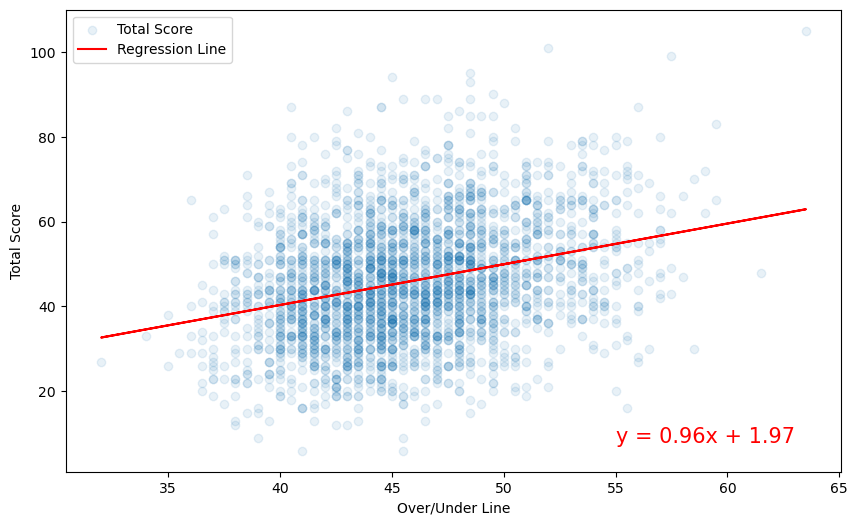

In [26]:
# Plot the data comparing the over_under_line to the total_score with regression line
def plot_linear_regression(x_values, y_values, ylabel, coordinates):
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(round(slope, 2)) + "x + " + str(round(intercept, 2))

    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(x_values, y_values, alpha=0.1, label='Total Score')

    # Add the regression line to the plot
    plt.plot(x_values, regress_values, color='red', label='Regression Line')

    # Annotate the equation on the plot
    plt.annotate(line_eq, coordinates, fontsize=15, color="red")

    # Set the title and labels for the axes
    plt.xlabel('Over/Under Line')
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()
                                                           
decade1['over_under_line'] = pd.to_numeric(decade1['over_under_line'], errors='coerce')
decade1['total_score'] = pd.to_numeric(decade1['total_score'], errors='coerce')

# Your x and y values

x_values = decade1['over_under_line']
y_values = decade1['total_score']

plot_linear_regression(x_values, y_values, 'Total Score', (55, 8))


C:\Users\Owner\AppData\Local\Temp\ipykernel_2484\479222831.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  decade2['over_under_line'] = pd.to_numeric(decade2['over_under_line'], errors='coerce')
C:\Users\Owner\AppData\Local\Temp\ipykernel_2484\479222831.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  decade2['total_score'] = pd.to_numeric(decade2['total_score'], errors='coerce')


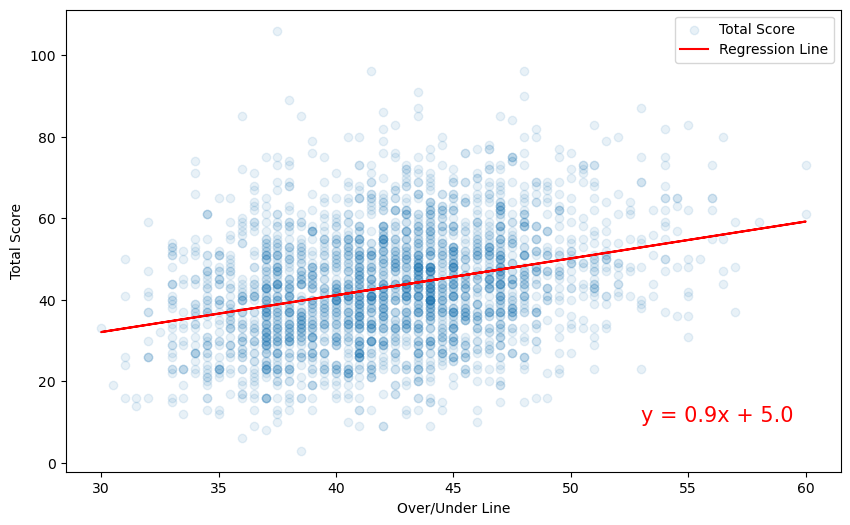

In [27]:
decade2['over_under_line'] = pd.to_numeric(decade2['over_under_line'], errors='coerce')
decade2['total_score'] = pd.to_numeric(decade2['total_score'], errors='coerce')

# Your x and y values

x_values = decade2['over_under_line']
y_values = decade2['total_score']

plot_linear_regression(x_values, y_values, 'Total Score', (53, 10))

C:\Users\Owner\AppData\Local\Temp\ipykernel_2484\1062869505.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  decade3['over_under_line'] = pd.to_numeric(decade3['over_under_line'], errors='coerce')
C:\Users\Owner\AppData\Local\Temp\ipykernel_2484\1062869505.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  decade3['total_score'] = pd.to_numeric(decade3['total_score'], errors='coerce')


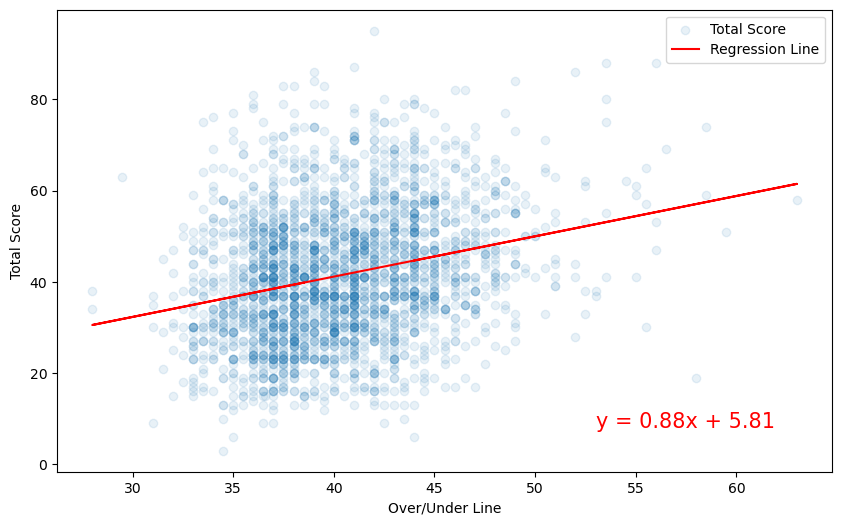

In [28]:
decade3['over_under_line'] = pd.to_numeric(decade3['over_under_line'], errors='coerce')
decade3['total_score'] = pd.to_numeric(decade3['total_score'], errors='coerce')

# Your x and y values

x_values = decade3['over_under_line']
y_values = decade3['total_score']

plot_linear_regression(x_values, y_values, 'Total Score', (53, 8))

In [41]:
superbowl_df = filtered_scores_data.loc[(filtered_scores_data['schedule_week'] == "Superbowl" ),:]
renamed_team_col = superbowl_df.rename(columns={"team_favorite_id":"team_favorite"})
renamed_team_col

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail,total_score,accuracy
2733,1980-01-20,1979,Superbowl,True,Los Angeles Rams,19.0,31.0,Pittsburgh Steelers,PIT,-10.5,36.0,Rose Bowl,True,67.0,30.0,NaN,NaN,50.0,138.89
2966,1981-01-25,1980,Superbowl,True,Oakland Raiders,27.0,10.0,Philadelphia Eagles,PHI,-3.0,37.5,Louisiana Superdome,True,72.0,0.0,NaN,indoor,37.0,98.67
3199,1982-01-24,1981,Superbowl,True,San Francisco 49ers,26.0,21.0,Cincinnati Bengals,SF,-1.0,48.0,Pontiac Silverdome,True,72.0,0.0,NaN,indoor,47.0,97.92
3340,1983-01-30,1982,Superbowl,True,Miami Dolphins,17.0,27.0,Washington Redskins,MIA,-3.0,36.5,Rose Bowl,True,61.0,NaN,NaN,NaN,44.0,120.55
3573,1984-01-22,1983,Superbowl,True,Washington Redskins,9.0,38.0,Los Angeles Raiders,WAS,-3.0,48.0,Tampa Stadium,True,68.0,25.0,NaN,NaN,47.0,97.92
3806,1985-01-20,1984,Superbowl,True,San Francisco 49ers,38.0,16.0,Miami Dolphins,SF,-3.5,53.5,Stanford Stadium,True,53.0,NaN,NaN,NaN,54.0,100.93
4039,1986-01-26,1985,Superbowl,True,Chicago Bears,46.0,10.0,New England Patriots,CHI,-10.0,37.5,Louisiana Superdome,True,72.0,0.0,NaN,indoor,56.0,149.33
4272,1987-01-25,1986,Superbowl,True,New York Giants,39.0,20.0,Denver Broncos,NYG,-9.5,40.0,Rose Bowl,True,76.0,NaN,NaN,NaN,59.0,147.50
4449,1988-01-31,1987,Superbowl,True,Denver Broncos,10.0,42.0,Washington Redskins,DEN,-3.0,47.0,Jack Murphy Stadium,True,61.0,10.0,NaN,NaN,52.0,110.64
4682,1989-01-22,1988,Superbowl,True,San Francisco 49ers,20.0,16.0,Cincinnati Bengals,SF,-7.0,48.0,Joe Robbie Stadium,True,76.0,25.0,NaN,NaN,36.0,75.00


In [53]:
teams = {"PIT": "Pittsburgh Steelers", "PHI": "Philadelphia Eagles", "SF": "San Franciso 49ers", "MIA": "Miami Dolphins", \
         "WAS": "Washington Redskins", "CHI": "Chicago Bears", "NYG": "New York Giants", "BUF": "Buffalo Bills", \
         "DAL": "Dallas Cowboys", "GB": "Green Bay Packers", "DEN": "Denver Broncos", "LAR": "St. Louis Rams", "BAL": "Baltimore Ravens", \
         "LVR": "Oakland Raiders", "NE": "New England Patriots", "IND": "Indiananpolis Colts", "CAR": "Carolina Panthers", \
         "KC": "Kansas City Chiefs"}
renamed_team_col["team_favorite"].replace(teams, inplace = True)
renamed_team_col

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail,total_score,accuracy
2733,1980-01-20,1979,Superbowl,True,Los Angeles Rams,19.0,31.0,Pittsburgh Steelers,Pittsburgh Steelers,-10.5,36.0,Rose Bowl,True,67.0,30.0,NaN,NaN,50.0,138.89
2966,1981-01-25,1980,Superbowl,True,Oakland Raiders,27.0,10.0,Philadelphia Eagles,Philadelphia Eagles,-3.0,37.5,Louisiana Superdome,True,72.0,0.0,NaN,indoor,37.0,98.67
3199,1982-01-24,1981,Superbowl,True,San Francisco 49ers,26.0,21.0,Cincinnati Bengals,San Francisco 49ers,-1.0,48.0,Pontiac Silverdome,True,72.0,0.0,NaN,indoor,47.0,97.92
3340,1983-01-30,1982,Superbowl,True,Miami Dolphins,17.0,27.0,Washington Redskins,Miami Dolphins,-3.0,36.5,Rose Bowl,True,61.0,NaN,NaN,NaN,44.0,120.55
3573,1984-01-22,1983,Superbowl,True,Washington Redskins,9.0,38.0,Los Angeles Raiders,Washington Redskins,-3.0,48.0,Tampa Stadium,True,68.0,25.0,NaN,NaN,47.0,97.92
3806,1985-01-20,1984,Superbowl,True,San Francisco 49ers,38.0,16.0,Miami Dolphins,San Francisco 49ers,-3.5,53.5,Stanford Stadium,True,53.0,NaN,NaN,NaN,54.0,100.93
4039,1986-01-26,1985,Superbowl,True,Chicago Bears,46.0,10.0,New England Patriots,Chicago Bears,-10.0,37.5,Louisiana Superdome,True,72.0,0.0,NaN,indoor,56.0,149.33
4272,1987-01-25,1986,Superbowl,True,New York Giants,39.0,20.0,Denver Broncos,New York Giants,-9.5,40.0,Rose Bowl,True,76.0,NaN,NaN,NaN,59.0,147.50
4449,1988-01-31,1987,Superbowl,True,Denver Broncos,10.0,42.0,Washington Redskins,Denver Broncos,-3.0,47.0,Jack Murphy Stadium,True,61.0,10.0,NaN,NaN,52.0,110.64
4682,1989-01-22,1988,Superbowl,True,San Francisco 49ers,20.0,16.0,Cincinnati Bengals,San Francisco 49ers,-7.0,48.0,Joe Robbie Stadium,True,76.0,25.0,NaN,NaN,36.0,75.00


In [61]:
outcome_df = renamed_team_col.copy()
reduced_outcome_df = outcome_df[['schedule_date','schedule_season', 'team_home', 'score_home', 'score_away', 'team_away', 'team_favorite', \
                                 'spread_favorite', 'over_under_line', 'accuracy']]
reduced_outcome_df.head()

,schedule_date,schedule_season,team_home,score_home,score_away,team_away,team_favorite,spread_favorite,over_under_line,accuracy
2733,1980-01-20,1979,Los Angeles Rams,19.0,31.0,Pittsburgh Steelers,Pittsburgh Steelers,-10.5,36.0,138.89
2966,1981-01-25,1980,Oakland Raiders,27.0,10.0,Philadelphia Eagles,Philadelphia Eagles,-3.0,37.5,98.67
3199,1982-01-24,1981,San Francisco 49ers,26.0,21.0,Cincinnati Bengals,San Francisco 49ers,-1.0,48.0,97.92
3340,1983-01-30,1982,Miami Dolphins,17.0,27.0,Washington Redskins,Miami Dolphins,-3.0,36.5,120.55
3573,1984-01-22,1983,Washington Redskins,9.0,38.0,Los Angeles Raiders,Washington Redskins,-3.0,48.0,97.92


In [68]:
def determine_winner(column):
    if column['score_home'] > column['score_away']:
        return column['team_home']
    else:
        return column['team_away']
reduced_outcome_df['winner'] = reduced_outcome_df.apply(determine_winner, axis=1)
reduced_outcome_df

C:\Users\Owner\AppData\Local\Temp\ipykernel_2484\2913287217.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_outcome_df['winner'] = reduced_outcome_df.apply(determine_winner, axis=1)


,schedule_date,schedule_season,team_home,score_home,score_away,team_away,team_favorite,spread_favorite,over_under_line,accuracy,winner
2733,1980-01-20,1979,Los Angeles Rams,19.0,31.0,Pittsburgh Steelers,Pittsburgh Steelers,-10.5,36.0,138.89,Pittsburgh Steelers
2966,1981-01-25,1980,Oakland Raiders,27.0,10.0,Philadelphia Eagles,Philadelphia Eagles,-3.0,37.5,98.67,Oakland Raiders
3199,1982-01-24,1981,San Francisco 49ers,26.0,21.0,Cincinnati Bengals,San Francisco 49ers,-1.0,48.0,97.92,San Francisco 49ers
3340,1983-01-30,1982,Miami Dolphins,17.0,27.0,Washington Redskins,Miami Dolphins,-3.0,36.5,120.55,Washington Redskins
3573,1984-01-22,1983,Washington Redskins,9.0,38.0,Los Angeles Raiders,Washington Redskins,-3.0,48.0,97.92,Los Angeles Raiders
3806,1985-01-20,1984,San Francisco 49ers,38.0,16.0,Miami Dolphins,San Francisco 49ers,-3.5,53.5,100.93,San Francisco 49ers
4039,1986-01-26,1985,Chicago Bears,46.0,10.0,New England Patriots,Chicago Bears,-10.0,37.5,149.33,Chicago Bears
4272,1987-01-25,1986,New York Giants,39.0,20.0,Denver Broncos,New York Giants,-9.5,40.0,147.50,New York Giants
4449,1988-01-31,1987,Denver Broncos,10.0,42.0,Washington Redskins,Denver Broncos,-3.0,47.0,110.64,Washington Redskins
4682,1989-01-22,1988,San Francisco 49ers,20.0,16.0,Cincinnati Bengals,San Francisco 49ers,-7.0,48.0,75.00,San Francisco 49ers


In [69]:
def accuracy(column):
    if column['winner'] == column['team_favorite']:
        return 'correct'
    else:
        return 'incorrect'
reduced_outcome_df['prediction'] = reduced_outcome_df.apply(accuracy, axis=1)
reduced_outcome_df

C:\Users\Owner\AppData\Local\Temp\ipykernel_2484\3720267363.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_outcome_df['prediction'] = reduced_outcome_df.apply(accuracy, axis=1)


,schedule_date,schedule_season,team_home,score_home,score_away,team_away,team_favorite,spread_favorite,over_under_line,accuracy,winner,prediction
2733,1980-01-20,1979,Los Angeles Rams,19.0,31.0,Pittsburgh Steelers,Pittsburgh Steelers,-10.5,36.0,138.89,Pittsburgh Steelers,correct
2966,1981-01-25,1980,Oakland Raiders,27.0,10.0,Philadelphia Eagles,Philadelphia Eagles,-3.0,37.5,98.67,Oakland Raiders,incorrect
3199,1982-01-24,1981,San Francisco 49ers,26.0,21.0,Cincinnati Bengals,San Francisco 49ers,-1.0,48.0,97.92,San Francisco 49ers,correct
3340,1983-01-30,1982,Miami Dolphins,17.0,27.0,Washington Redskins,Miami Dolphins,-3.0,36.5,120.55,Washington Redskins,incorrect
3573,1984-01-22,1983,Washington Redskins,9.0,38.0,Los Angeles Raiders,Washington Redskins,-3.0,48.0,97.92,Los Angeles Raiders,incorrect
3806,1985-01-20,1984,San Francisco 49ers,38.0,16.0,Miami Dolphins,San Francisco 49ers,-3.5,53.5,100.93,San Francisco 49ers,correct
4039,1986-01-26,1985,Chicago Bears,46.0,10.0,New England Patriots,Chicago Bears,-10.0,37.5,149.33,Chicago Bears,correct
4272,1987-01-25,1986,New York Giants,39.0,20.0,Denver Broncos,New York Giants,-9.5,40.0,147.50,New York Giants,correct
4449,1988-01-31,1987,Denver Broncos,10.0,42.0,Washington Redskins,Denver Broncos,-3.0,47.0,110.64,Washington Redskins,incorrect
4682,1989-01-22,1988,San Francisco 49ers,20.0,16.0,Cincinnati Bengals,San Francisco 49ers,-7.0,48.0,75.00,San Francisco 49ers,correct


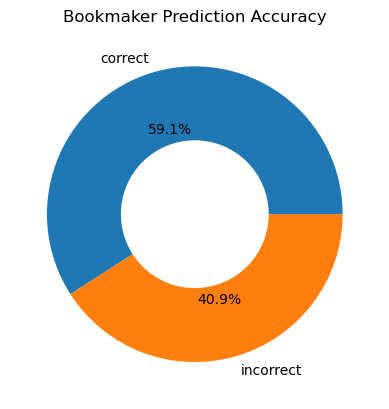

In [78]:
#Create chart
sb_pie = reduced_outcome_df.groupby("prediction")
sb_pie_count = sb_pie["prediction"].count()
plot = sb_pie_count.plot(kind = "pie", autopct="%1.1f%%")

#Inner circle
center_circle = plt.Circle((0,0),0.50,fc='white')
fig = plt.gcf()
fig.gca().add_artist(center_circle)
plt.ylabel("")
plt.title("Bookmaker Prediction Accuracy")
plt.show()